# A closure study - can we extract $m_A=0.99$ GeV from the distirbution of the truth-$Q^2$ using GENIE event weight?

In [1]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mAextraction/Figures/EventWeight/'

In [3]:
versions['overlay date'] = '2018_07_10'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'

In [4]:
OverlayPairsFV, OverlaySamples = load_MCbnbDATAcosmicSamples(date=versions['overlay date'],filename=versions['Overlay']+'_'+versions['overlay date']+'_vertices')

285038 pairs from MC-BNB + cosmic DATA overlay
187286 pairs in FV
49951 are 1mu-1p, 26.7%
41680 are other pairs, 22.3%
95655 are cosmic, 51.1%
--------------------------------------------------------------
24119 are CC 1p 0pi, 12.9%
I finished loading overlay, MC BNB / data cosmic samples. We have in total 285038 pairs


## 2. apply the event-selection cuts

In [5]:
cuts_order  = ['no cut','Chi2Proton','MatchedFlash','length','non-collinearity','vertex activity','delta phi','Pt & delta phi']
reducedOverlay,pureffOverlay,pureffNumbers = apply_cuts_to_overlay(OverlaySamples=OverlaySamples, cuts_order=cuts_order)
print 'applied cuts to overlay'

applied cuts to overlay


In [6]:
selected_overlay=dict()
for pair_type in pair_types:
    selected_overlay[pair_type] = reducedOverlay['Pt & delta phi'][pair_type]
selected_overlay_concat = pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])    
print len(pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])),'events in the overlay'
selected_CC1p0pi = selected_overlay['CC 1p 0pi']
print len(selected_CC1p0pi),'selected CC 1p 0pi pairs in overlay'

8978 events in the overlay
6979 selected CC 1p 0pi pairs in overlay


## 3. compare the shapes and rates after the event-selection cuts

In [7]:
# in current version there is a mistake and weight of '040' is actually for mA=0.65
mA_array = [0.65,0.70,0.80,0.95,0.99,1.00,1.10,1.15,1.35,1.71]
mA_names = ['040','070','080','095','099','100','110','115','135','171']

In [8]:
def sample_quasidata_from_overlay(selected_overlay=None,Nrand=1):
    quasidataSamples = dict()
    for pair_type in pair_types:#{
        nrand_pair_type = int(len(selected_overlay[pair_type])*Nrand/len(selected_overlay_concat))
        quasidataSamples[pair_type] = selected_overlay[pair_type].sample(n=nrand_pair_type)
    return pd.concat([quasidataSamples['1mu-1p'],quasidataSamples['cosmic'],quasidataSamples['other pairs']])

# compare using Likelihood
The way we do it is by separating Likelihood to the number of events $\times$ the likelihood to the shape
$$ \hat l(data \; | \;m_A) = l(N_{data} \; | \;m_A-integral) \times l(data \; | \;m_A-shape)
$$
where 
$$
l(N_{data} \; | \;m_A-integral) = P_{Poisson} (N_{data} \; | \; \int dQ^2 (m_A))
$$

assuming a Poisson distribution for the number of events with $m_A$ as input $I_{m_A} = \int dQ^2 (m_A)$, 

$$
    l(N_{data} \; | \;m_A-integral) 
    = \frac{e^{-{I_{m_A}}}}{(N_{data})!} (I_{m_A})^{N_{data}} 
    \sim
    \frac{e^{N_{data}-{I_{m_A}}}}{ \sqrt{2\pi N_{data}} } \left(\frac{I_{m_A}}{N_{data}}\right)^{N_{data}}
$$



In [9]:
from scipy.stats import distributions
from pyqt_fit import kde

Warning, cannot import Cython kernel functions, pure python functions will be used instead


In [11]:
pdf_dict = dict()
mc = selected_overlay_concat
mc_array = np.array(mc['closest_genie_Q2'])

kde1d_pdf,weighted_pdf=dict(),dict()
for mA,name in zip(mA_array,mA_names):
    mc_weights = np.array(mc['evwgh_mA'+name+'_Genie'])    
    weighted_pdf[mA] = kde.KDE1D(mc_array, weights=mc_weights, bandwidth=.01)
    kde1d_pdf[mA] = kde.KDE1D(mc_array, bandwidth=.01)
print 'done.'

done.


In [13]:
Nrand = 350 # len(selected_overlay_concat)
quasidata_time = float(Nrand) / len(selected_overlay_concat)

quasidata = sample_quasidata_from_overlay(selected_overlay=selected_overlay,Nrand=Nrand+1)
quasidata_array = np.array(quasidata['closest_genie_Q2'])
N_data = float(len(quasidata_array))

mc = selected_overlay_concat
mc_array = np.array(mc['closest_genie_Q2'])
I_mc,I_mc_normalized,P_poisson = dict(),dict(),dict()

results = pd.DataFrame(columns=mA_array)
P_integral_arr,LL_integral_arr,LL_pdf_arr,LL_arr = [],[],[],[]

for mA,name in zip(mA_array,mA_names):
    mc_weights = np.array(mc['evwgh_mA'+name+'_Genie'])    
    I_mc[mA] = np.sum(mc_weights)
    I_mc_normalized[mA] = I_mc[mA]*quasidata_time    
    P_poisson[mA] = distributions.poisson.pmf(N_data , I_mc_normalized[mA])    
    P_integral_arr.append(P_poisson[mA])
    
    LL_integral = np.log(P_poisson[mA])
    LL_integral_arr.append(LL_integral)
    
    P_pdf = weighted_pdf[mA](quasidata_array)
    LL_pdf = np.sum(np.log(P_pdf))
    LL_pdf_arr.append(LL_pdf)
    
    LL = LL_integral + LL_pdf
    LL_arr.append(LL) 
    
print 'done generating %d quasi-data events and comparing them to different GENIE weights.'%N_data

done generating 350 quasi-data events and comparing them to different GENIE weights.


/usr/local/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:48: ComplexWarning: Casting complex values to real discards the imaginary part


$m_A=0.97^{+0.03}_{-0.02}$ GeV/c$^2$


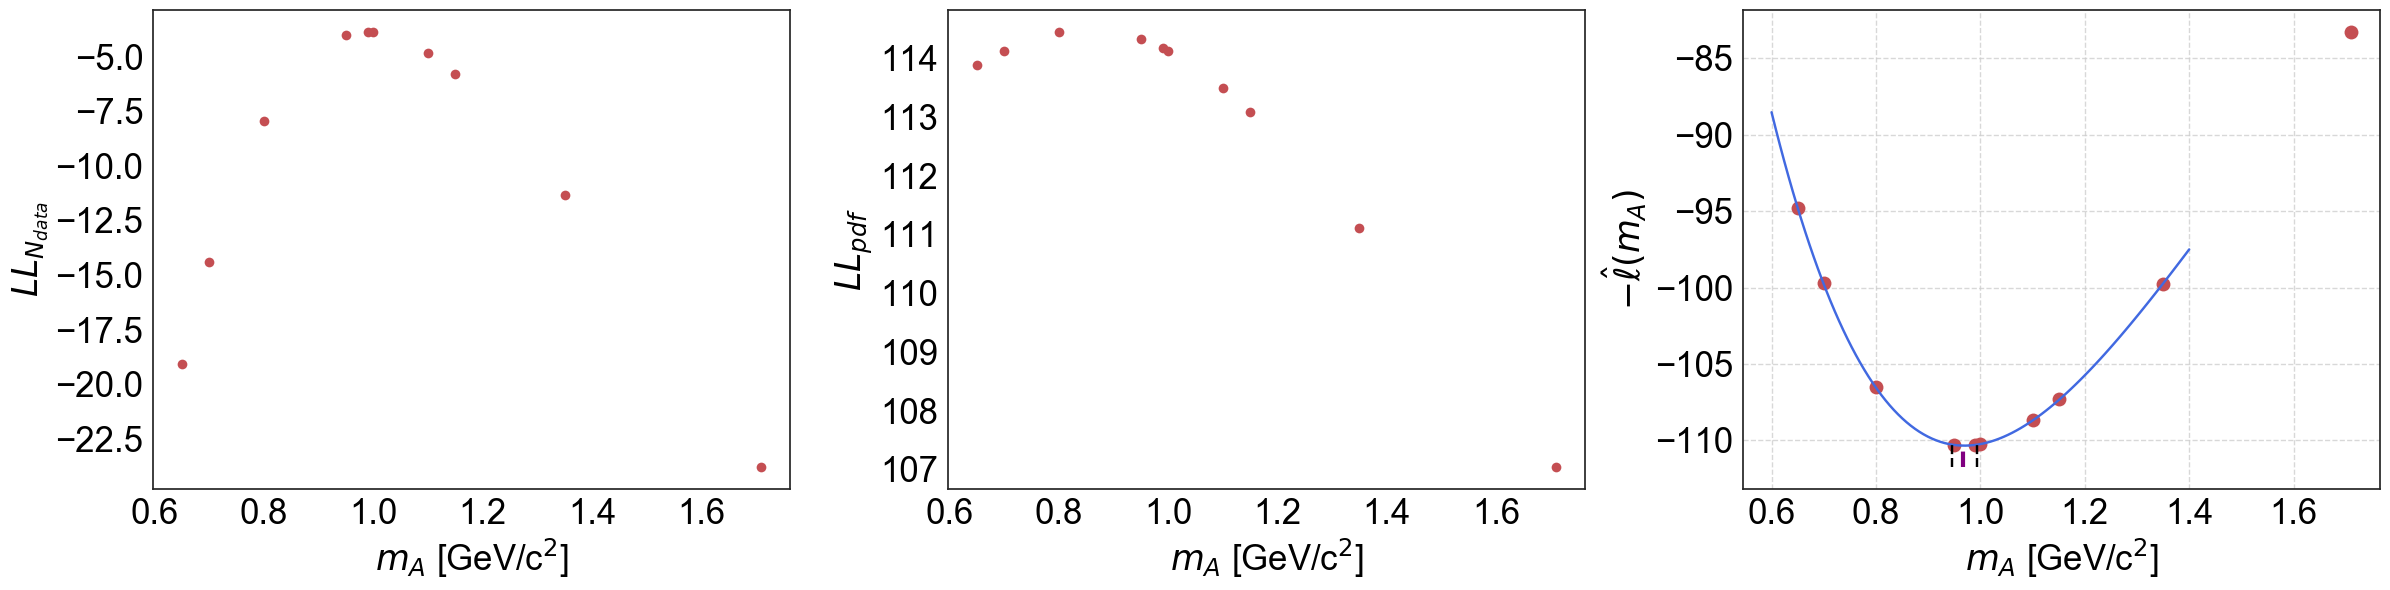

In [14]:
fig=plt.figure(figsize=(24,6));
ax = fig.add_subplot(1,3,1)
plt.errorbar(x=mA_array,y=LL_integral_arr,fmt='ro',color='black')
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$LL_{N_{data}}$')

ax = fig.add_subplot(1,3,2)
plt.errorbar(x=mA_array,y=LL_pdf_arr,fmt='ro',color='black')
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$LL_{pdf}$')


ax = fig.add_subplot(1,3,3)

x,y = mA_array , -np.array(LL_arr)
deg = 4
p,cov = np.polyfit(x,y,deg=deg,cov=True)
poly = np.poly1d(p)    
plt.plot( x,y , 'ro',markersize=10,linewidth=2,label='LL')
x_poly = linspace(0.6,1.4,100)
y_poly = poly(x_poly)
y_MLE = np.min(poly(x_poly))
x_MLE = find_x_poly(poly,y_MLE,xmin=0.6,xmax=1.4)

plt.plot(x_poly,y_poly,'-',color='royalblue',label='polynomial fit')    

# Matrix with rows 1, t, t**2, ...:
TT = np.vstack([x_poly**(deg-i) for i in range(deg+1)]).T
Cov_poly = np.dot(TT, np.dot(cov, TT.T)) # C_y = TT*C_z*TT.T
sig_poly = np.sqrt(np.diag(Cov_poly))  # Standard deviations are sqrt of diagonal
poly_up = np.poly1d(np.polyfit(x_poly,poly(x_poly)+sig_poly,deg=deg))
poly_dw = np.poly1d(np.polyfit(x_poly,poly(x_poly)-sig_poly,deg=deg))
ax.fill_between(x_poly, poly(x_poly)+sig_poly, poly(x_poly)-sig_poly, alpha=.25)

TT_x_MLE = np.vstack([np.array([x_MLE])**(deg-i) for i in range(deg+1)]).T
Cov_MLE = np.dot(TT_x_MLE, np.dot(cov, TT_x_MLE.T)) # C_y = TT*C_z*TT.T
sig_MLE = np.sqrt(np.diag(Cov_MLE))  # Standard deviations are sqrt of diagonal
MLE_top = y_MLE + sig_MLE

ymin = np.min(ax.get_ylim())
plt.plot([x_MLE,x_MLE],[ymin,y_MLE],'--',linewidth=3,color='purple',label='MLE')
MLE = poly(x_MLE)
x_MLE_dw = find_x_poly(poly_dw,MLE_top,xmin=0.6,xmax=x_MLE); x_MLE_dw_err = x_MLE - x_MLE_dw
x_MLE_up = find_x_poly(poly_dw,MLE_top,xmin=x_MLE,xmax=1.4); x_MLE_up_err = x_MLE_up - x_MLE
plt.plot(        
        [x_MLE_dw,x_MLE_dw],[ymin,MLE_top],'--'
        ,[x_MLE_up,x_MLE_up],[ymin,MLE_top],'--'
#         ,[x_MLE_dw,x_MLE_up],[MLE_top,MLE_top],'-'
        ,color='black',label='68.3% confidence')
string = '$m_A=%.2f^{+%.2f}_{-%.2f}$ GeV/c$^2$'%(x_MLE,x_MLE_up_err,x_MLE_dw_err)
print string
# plt.text(0.6,-85,string,fontsize=30)
set_axes(ax,r'$m_A$ [GeV/c$^2$]','$-{\hat {\ell }}(m_{A})$',do_add_grid=True)
plt.tight_layout()

# Compare using $\chi^2$ comparison

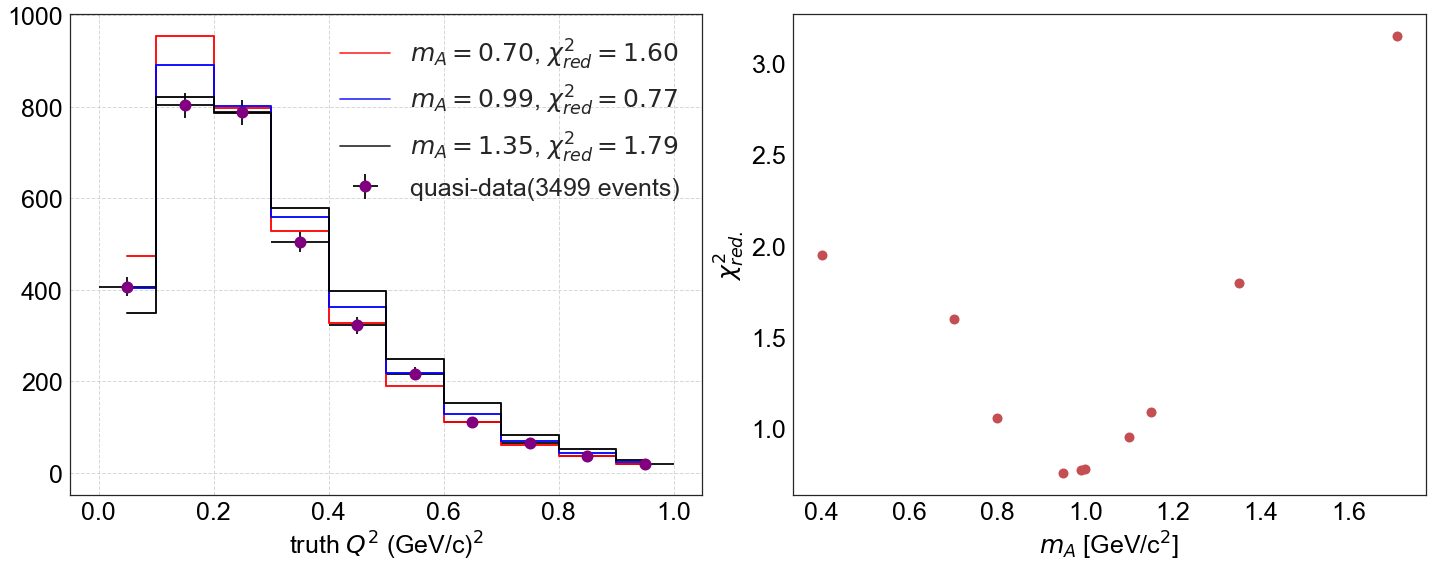

In [9]:
Nrand = 3500 # len(selected_overlay_concat)
bins = linspace(0,1,11); mid = 0.5*(bins[1:]+bins[:-1])
chi2_xrange = (0.,1)

fig=plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1)

quasidata = sample_quasidata_from_overlay(selected_overlay=selected_overlay,Nrand=Nrand+1)

mc = selected_overlay
h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=quasidata,color='purple',var='truth_Q2',label='quasi-data', bins=bins, markersize=12, ax=ax, do_return_h=True)

for mA,name,color in zip([0.7,0.99,1.35],['070','099','135'],['red','blue','black']):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc, norm=Nrand
                                                   , ax=ax
                                                   , var='truth_Q2'
                                                   , weights_var='evwgh_mA'+name+'_Genie', bins=bins
                                                   , do_individual_histograms=False, stackColor=color
                                                   , stackLabel=None)
    if chi2_xrange is not None:
        chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
        h_overlay,_=plot_stacked_MCsamples( OverlaySamples=mc, norm=Nrand
                                           , ax=ax
                                           , var='truth_Q2'
                                           , weights_var='evwgh_mA'+name+'_Genie'
                                           , bins=bins, do_individual_histograms=False, stackColor=color
                                           ,stackLabel='$m_A=%.2f$'%mA+', $\chi^2_{red}=%.2f$'%(chi2/ndf))
set_axes(ax,r'truth $Q^2$ (GeV/c)$^2$','',do_add_legend=True,legend_loc='upper right')


ax = fig.add_subplot(1,2,2)
chi2_red = []
for mA,name in zip(mA_array,mA_names):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc, norm=Nrand, do_draw=False, var='truth_Q2', weights_var='evwgh_mA'+name+'_Genie', bins=bins)
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
    chi2_red.append(chi2/ndf)
plt.errorbar(mA_array,chi2_red,fmt='ro',markersize=10)
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$\chi^2_{red.}$')
plt.tight_layout()

In [10]:
Nrand = 350
Nexpriments = 100
results_experiments = pd.DataFrame(columns=mA_array)
mc = selected_overlay
h_overlay,h_overlay_err=dict(),dict()
for mA,name in zip(mA_array,mA_names):
    h_overlay[mA],h_overlay_err[mA]=plot_stacked_MCsamples( OverlaySamples=mc, norm=Nrand, do_draw=False, var='truth_Q2', weights_var='evwgh_mA'+name+'_Genie', bins=bins)

for i in range(Nexpriments):    
    if Nexpriments>10 and i%(Nexpriments/10)==0: print 'running quasiexperiment',i
    quasidata = sample_quasidata_from_overlay(selected_overlay=selected_overlay,Nrand=Nrand+1)
    h_quasidata,h_quasidata_err=plot_OnBeam(OnBeamSample=quasidata,color='purple',var='truth_Q2',label='quasi-data', bins=bins, markersize=12, ax=ax, do_return_h=True,do_draw=False)    
    res = dict()
    for mA,name in zip(mA_array,mA_names):
        chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                             , h1=h_quasidata , h1err=h_quasidata_err
                                             , h2=h_overlay[mA]   ,  h2err=h_overlay_err[mA]
                                             , debug=0)
        res[mA] = (chi2/ndf)
    results_experiments.loc[i] = res
print 'done running %d quasiexperiments.'%Nexpriments

running quasiexperiment 0
running quasiexperiment 10
running quasiexperiment 20
running quasiexperiment 30
running quasiexperiment 40
running quasiexperiment 50
running quasiexperiment 60
running quasiexperiment 70
running quasiexperiment 80
running quasiexperiment 90
done running 100 quasiexperiments.


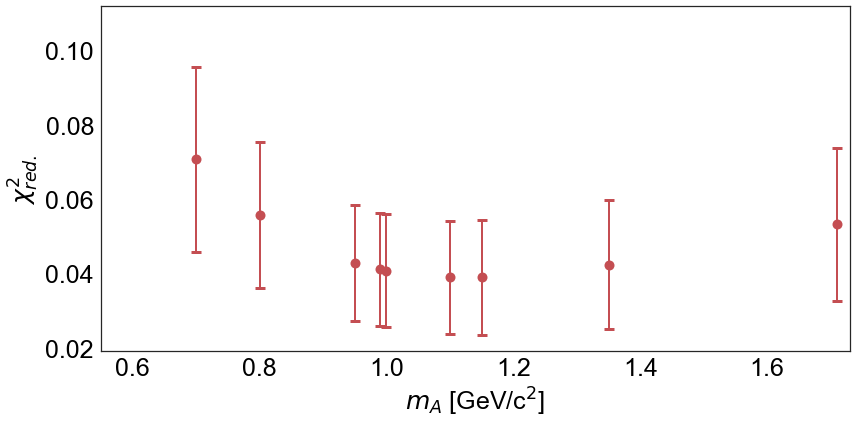

In [11]:
fig=plt.figure(figsize=(12,6));
ax=fig.add_subplot(1,1,1)
chi2_mean,chi2_std = [],[]
for mA in mA_array:
    chi2_mean.append(np.mean(results_experiments[mA]))
    chi2_std.append(np.std(results_experiments[mA]))
plt.errorbar( x=mA_array,y=chi2_mean,yerr=chi2_std , fmt='ro',markersize=10,linewidth=2,capsize=5,capthick=3)
set_axes(ax,r'$m_A$ [GeV/c$^2$]','$\chi^2_{red.}$',xlim=(0.55,1.73))
plt.tight_layout()

# compare using KS test

In [12]:
from scipy import stats
from scipy.stats import distributions

In [13]:
#  -- - -- -- - -- - - - - - - - - ---- -- ---- 
# July-05,2018
def weighted_repeat(array, weights, epsilon=0.01,debug=0):
    '''
    written for KS test using standard (non-weighted) arrays
    
    input:
    array + weights
    
    return:
    repeated array representing the weighted array
    
    '''
    w_min = np.max([epsilon ,np.min(weights)])
    weights_as_repetition_numbers = np.array([np.max([1,int(round(w/w_min))]) for w in weights])
    if debug:
        print 'array:',array
        print 'weights:',weights
        print 'w_min:',w_min
        print 'weights_as_repetition_numbers:',weights_as_repetition_numbers
    repeated_array = np.repeat(array, weights_as_repetition_numbers, axis=0)
    if debug:
        print 'repeated_array:',repeated_array
    return repeated_array
#  -- - -- -- - -- - - - - - - - - ---- -- ---- 

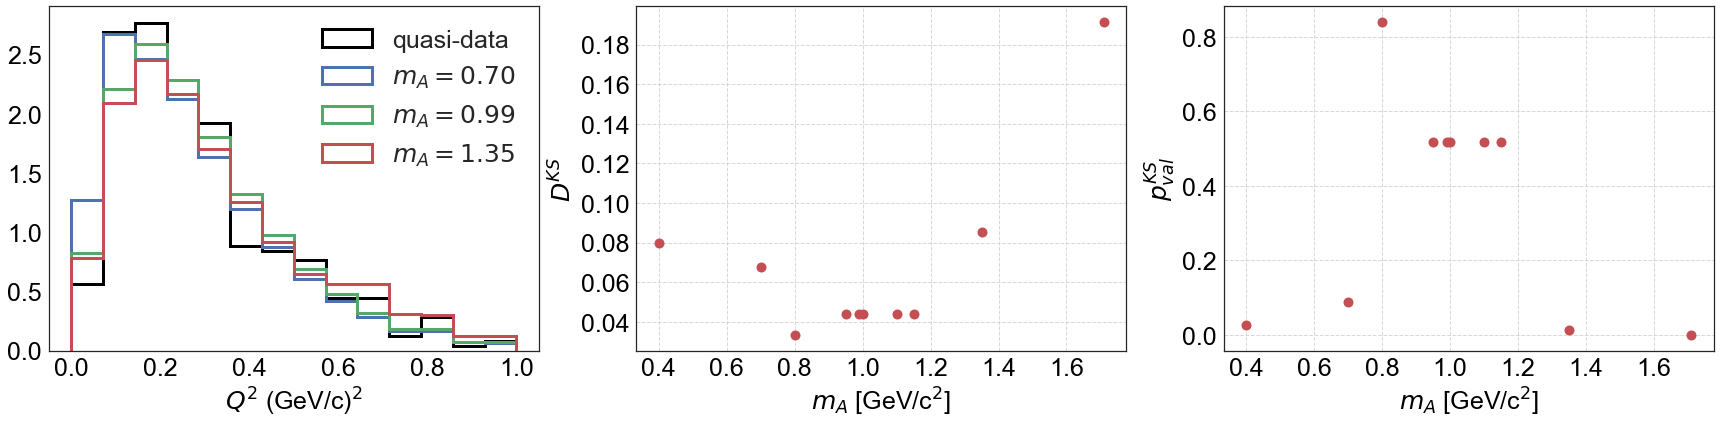

In [14]:
Nrand = 350 # len(selected_overlay_concat)-2

mc = selected_overlay_concat
mc_array = np.array(mc['closest_genie_Q2'])

quasidata = sample_quasidata_from_overlay(selected_overlay=selected_overlay,Nrand=Nrand+1)
quasidata_array = np.array(quasidata['closest_genie_Q2'])


bins=linspace(0,1,15)
fig=plt.figure(figsize=(24,6));
ax = fig.add_subplot(1,3,1)
plt.hist(quasidata_array,bins=bins,normed=1,label='quasi-data',histtype='step',linewidth=3,color='black')


Pval_df = pd.DataFrame(columns={'mA','KS_D','KS_Pval','my_Pval'})
for mA,name in zip(mA_array,mA_names):
    mc_weights = np.array(mc['evwgh_mA'+name+'_Genie'])
    mc_repeated_array = weighted_repeat(mc_array, mc_weights,epsilon=0.1,debug=0 if mA!=0.7 else 0) 
    
    KS_D,KS_Pval = stats.ks_2samp(mc_repeated_array, quasidata_array)
    # we do not take standard KS_Pval,
    # as we want to compute the Pval for size n,
    # n-being the real number of events, not the repeated-array size...
    n1 = len(quasidata_array);n2 = len(mc_array)
    en = np.sqrt(n1 * n2 / float(n1 + n2))
    my_Pval = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * KS_D)
    Pval_df = Pval_df.append(pd.DataFrame({'mA':mA,'KS_D':KS_D,'KS_Pval':KS_Pval,'my_Pval':my_Pval},index=[mA]))    
    
    if mA in [0.7,0.99,1.35]:
        plt.hist(mc_repeated_array,bins=bins,normed=1,label='$m_A=%.2f$'%mA,histtype='step',linewidth=3)
        
set_axes(ax,r'$Q^2$ (GeV/c)$^2$','',do_add_legend=True)

ax = fig.add_subplot(1,3,2)
x,y = Pval_df['mA'] , Pval_df['KS_D']
plt.plot( x,y , 'ro',markersize=10,linewidth=2)
set_axes(ax,r'$m_A$ [GeV/c$^2$]','$D^{KS}$',do_add_grid=True)


ax = fig.add_subplot(1,3,3)
x,y = Pval_df['mA'] , Pval_df['my_Pval']
plt.plot( x,y , 'ro',markersize=10,linewidth=2)
set_axes(ax,r'$m_A$ [GeV/c$^2$]','$p_{val}^{KS}$',do_add_grid=True)
plt.tight_layout()

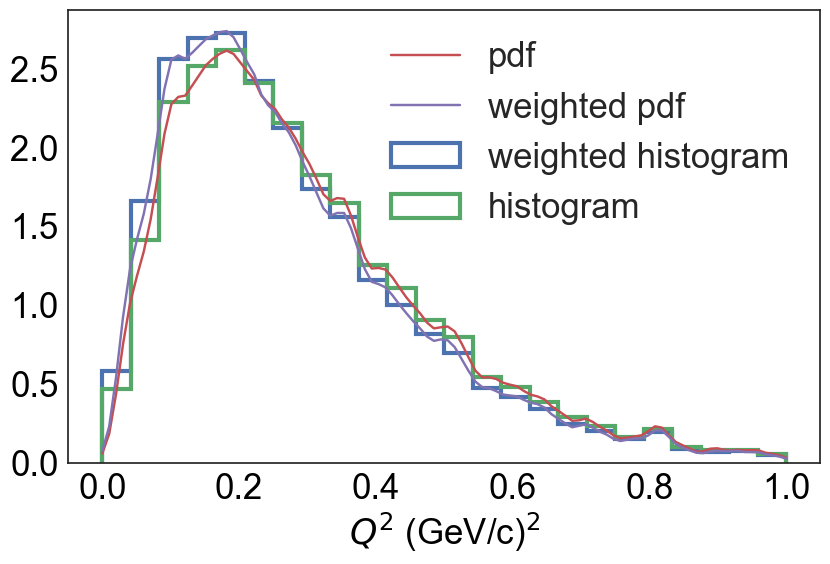

In [24]:
xs = linspace(0,1,100)


fig=plt.figure(figsize=(9.708,6));
ax = fig.add_subplot(1,1,1)
plt.hist(mc_array , weights=np.array(mc['evwgh_mA070_Genie']) ,bins=linspace(0,1,25), label='weighted histogram', normed=1,histtype='step',linewidth=3)
plt.hist(mc_array , bins=linspace(0,1,25), label='histogram', normed=1,histtype='step',linewidth=3)
plt.plot(xs, kde1d_pdf[0.7](xs), label='pdf')
plt.plot(xs, weighted_pdf[0.7](xs), label='weighted pdf')
set_axes(ax,r'$Q^2$ (GeV/c)$^2$','',do_add_legend=True,legend_loc='best')
